# <p style="text-align: center;">Assignment 3: Progress Report</p>
<p style="text-align: center;">Meichen Fang</p> 

## 1. What progress has been made so far towards your objectives described in your proposal
I haven't made much progress. Finding the appropriate datasets is harder than I thought. The datasets I planned to use couldn't be loaded. I looked at previous methods and found a paper using generative adversarial networks to obtain a universal representation of epidermal differentiation, which is similar to my goal in some way. Therefore, I used their datasets.

I wrote the basic autoencoder model and tried to train it. However, it seems that the reconstruction of data through autoencoder is really far away from the data. I am trying to find the reasons. 

I also wrote the variational autoencoder model but haven't been able to train it since the basic autoencoder model doesn't work.

## 2. Describe any challenges you are currently facing and how you are planning to overcome them
Currently, I don't think I found the most appropriate datasets for this task because there is no ground truth pseudotime or differentiational state labels. I will keep looking relavent articles.

What's more, as I said above, the autoencoder model works badly no matter how I change the latent dimension and the layers paramters. I am trying to find why.

Another problem is that I want to introduce some latent variables describing the fates of cells (like the ultimate differentiated state of cells) besides variables for pseudotime. For similar problem of age aggression/regression in the field of image, some methods used two kinds of variables representing ages and personalities separately. But here, the fates (cell "personalities") seems to be better represented by discrete variables, which I am not sure and don't know how to do. I am trying to find out what kind of latent layer or structure suits this problem best. 

## 3. What are your next steps?
I will read more papers using autoencoder or VAE and compare their code to chech whether my network is corret. I will also try to find better datasets. Most importantly, I will think about what kind of latent layer or network can be a good candidate for the representation of differentiations.

## 4. Code

### Import dependencies

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import umap
from sklearn.decomposition import PCA

In [4]:
print(sc.__version__)

1.6.0


### Load data
The scRNA dataset is downloaded from https://github.com/luslab/arshamg-scrnaseq-wgan/blob/master/data/four_datasets_combined_lTPM_red_small_clean.csv.zip

In [17]:
fname= './data/arshamg-scrnaseq-wgan_datasets.csv'
data = np.transpose(np.loadtxt(fname, delimiter=',', skiprows=1))
print(np.shape(data))

(2263, 6605)


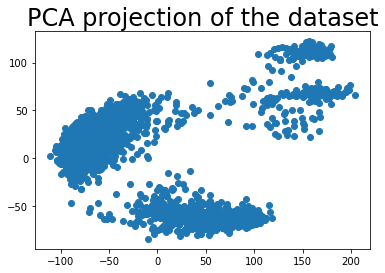

In [75]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(data)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
plt.title('PCA projection of the dataset', fontsize=24)
plt.show()

Visualize data using umap

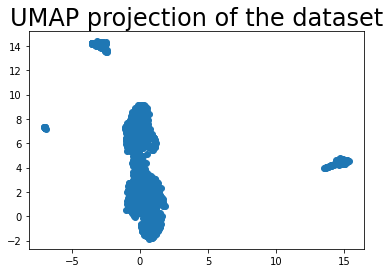

In [18]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title('UMAP projection of the dataset', fontsize=24)
plt.show()

Generate training, validation and test datasets

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(data, data, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5)

### Autoencoder model

In [90]:
class Autoencoder(Model):
  def __init__(self, latent_dim, input_shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(512, kernel_initializer='glorot_uniform'),
      layers.BatchNormalization(axis=1),
      layers.Dense(64, activation="relu"),
      #layers.BatchNormalization(axis=1),
      #layers.Dense(8, activation="relu"),
      layers.Dense(latent_dim, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.InputLayer(input_shape=(latent_dim,)),
      #layers.Dense(8, activation="relu"),
      #layers.BatchNormalization(axis=1),
      layers.Dense(64, activation="relu"),
      layers.BatchNormalization(axis=1),
      layers.Dense(512, activation="sigmoid"),
      layers.Dense(input_shape, activation="sigmoid")])


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [96]:
latent_dim = 10
input_shape = np.shape(data)[1]
autoencoder = Autoencoder(latent_dim, input_shape)

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(1e-4)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

Train the model

In [97]:
 history = autoencoder.fit(X_train, y_train, 
          epochs=50, 
          batch_size=256,
          validation_data=(X_val, y_val),
          shuffle=True)

Epoch 1/50
8/8 [==============================] - 1s 82ms/step - loss: 10.8708 - val_loss: 10.8604
Epoch 2/50
8/8 [==============================] - 1s 66ms/step - loss: 10.7874 - val_loss: 10.6876
Epoch 3/50
8/8 [==============================] - 1s 63ms/step - loss: 10.6023 - val_loss: 10.5163
Epoch 4/50
8/8 [==============================] - 1s 64ms/step - loss: 10.4853 - val_loss: 10.3538
Epoch 5/50
8/8 [==============================] - 1s 69ms/step - loss: 10.3160 - val_loss: 10.2083
Epoch 6/50
8/8 [==============================] - 1s 68ms/step - loss: 10.1589 - val_loss: 10.0817
Epoch 7/50
8/8 [==============================] - 1s 66ms/step - loss: 10.1748 - val_loss: 9.9771
Epoch 8/50
8/8 [==============================] - 1s 67ms/step - loss: 9.9984 - val_loss: 9.8929
Epoch 9/50
8/8 [==============================] - 1s 69ms/step - loss: 9.9497 - val_loss: 9.8286
Epoch 10/50
8/8 [==============================] - 1s 65ms/step - loss: 9.7592 - val_loss: 9.7782
Epoch 11/50
8/8 

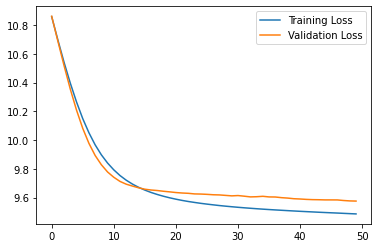

In [98]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

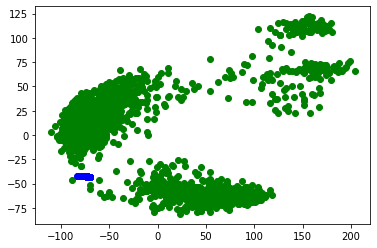

In [99]:
pseudocells = autoencoder.decoder(autoencoder.encoder(X_train)).numpy()
new_embedding = pca.transform(pseudocells)
old_embedding = pca.transform(X_train)

fig, ax = plt.subplots(1,1)
ax.scatter(old_embedding[:, 0], old_embedding[:, 1], c='g')
ax.scatter(new_embedding[:, 0], new_embedding[:, 1], c='b')
plt.show()

**Green is the input and blue is the output. It looks like that the autoencoder is not working.**

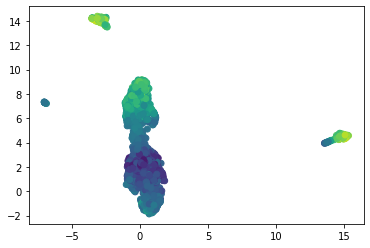

In [63]:
pseudotime = autoencoder.encoder(data).numpy()
pseudotime = (pseudotime-min(pseudotime))/(max(pseudotime)-min(pseudotime))
plt.scatter(embedding[:, 0], embedding[:, 1], c=pseudotime)
plt.show()

### variational autoencoder (VAE)

In [145]:
from keras import backend as K

class VAE(Model):
    def __init__(self, latent_dim, input_shape):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim  
        self.input_size = input_shape

    def _encoder(self, x):
        h = layers.Dense(512, kernel_initializer='glorot_uniform')(x)
        h = layers.BatchNormalization(axis=1)(h) 
        h = layers.Dense(64, activation="relu")(h)
        h = layers.BatchNormalization(axis=1)(h)

        mean = layers.Dense(self.latent_dim, activation="relu")(h)
        log_var = layers.Dense(self.latent_dim, activation="relu")(h)
        z = layers.Lambda(self._z, output_shape=(self.latent_dim,))([mean, log_var])
        
        return z

    def _z(self, args):
        mu, log_var = args
        batch_size = K.shape(mu)[0]
        z_dim = K.shape(mu)[1]
        eps = K.random_normal(shape=[batch_size, z_dim])
        return mu + K.exp(log_var / 2) * eps
            
    def _decoder(self, z):
        h = layers.Dense(64, activation="relu")(z)
        h = layers.BatchNormalization(axis=1)(h)
        h = layers.Dense(512, activation="sigmoid")(h)
        h = layers.Dense(self.input_size, activation="sigmoid")(h)
        
        return h


    def call(self, x):
        encoded = self._encoder(x)
        decoded = self._decoder(encoded)
        return decoded


In [146]:
latent_dim = 10
input_shape = np.shape(data)[1]
vae = VAE(latent_dim, input_shape)

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(1e-4)
vae.compile(optimizer=optimizer, loss=losses.MeanSquaredError())